In [2]:
# 测试环境
%run env.py
env = CombinatorialAuctionEnv(n_agents=5, n_items=3, max_steps=5)
obs = env.reset()
print("环境重置成功!")
print(f"观察: {obs}")
print(f"观察形状: {[o.shape for o in obs]}")

# 测试一步执5
actions = [env.action_space.sample() for _ in range(env.n_agents)]
print(f"随机动作: {actions}")

next_obs, rewards, done, info = env.step(actions)
print(f"执行成功! 奖励: {rewards}, 完成: {done}")
env.render()

环境重置成功!
观察: [array([4.15660402, 0.23757671, 4.6190144 , 0.        , 0.        ,
       0.        , 0.        ]), array([3.97594213, 8.75726189, 1.87571697, 0.        , 0.        ,
       0.        , 0.        ]), array([3.22197392, 6.51134227, 3.43051102, 0.        , 0.        ,
       0.        , 0.        ]), array([9.26427213, 6.52653976, 7.31628384, 0.        , 0.        ,
       0.        , 0.        ]), array([5.61798543, 9.40191959, 8.19965471, 0.        , 0.        ,
       0.        , 0.        ])]
观察形状: [(7,), (7,), (7,), (7,), (7,)]
随机动作: [array([3.0544262 , 9.110897  , 0.95116585], dtype=float32), array([3.418386 , 9.608634 , 5.4580374], dtype=float32), array([4.5801134, 8.121447 , 7.496291 ], dtype=float32), array([3.7037923, 6.9982333, 7.1727796], dtype=float32), array([3.234392  , 3.7237282 , 0.80586326], dtype=float32)]
执行成功! 奖励: [ 0.         -0.35363518 -4.22408696  0.          0.        ], 完成: False

=== 回合 1 ===
真实估值:
  智能体 0: [4.15660402 0.23757671 4.6190144 ]
  智能体

In [13]:
# 测试 MADDPG
%run maddpg.py

# 使用与环境相同的参数
n_agents = 2
obs_dims = [env.obs_dim] * n_agents  # 注意使用 env.obs_dim 而不是 env.n_items
act_dims = [env.n_items] * n_agents

maddpg = MADDPG(n_agents, obs_dims, act_dims)
print("MADDPG 初始化成功!")

# 测试动作生成
test_obs = env.reset()
test_actions = maddpg.act(test_obs)
print(f"MADDPG 生成的动作: {test_actions}")

MADDPG 初始化成功!
MADDPG 生成的动作: [array([0.37231618, 0.53775936, 0.44884092], dtype=float32), array([0.44975576, 0.6657661 , 0.56756955], dtype=float32)]


In [14]:
# 简化训练循环
import numpy as np

# 重置环境
obs_list = env.reset()
done = False
episode_reward = 0

while not done:
    # 使用 MADDPG 生成动作
    actions = maddpg.act(obs_list)
    
    # 执行动作
    next_obs_list, rewards, done, info = env.step(actions)
    episode_reward += np.sum(rewards)
    
    # 存储经验
    maddpg.buffer.add((obs_list, actions, rewards, next_obs_list, done))
    
    # 更新观察
    obs_list = next_obs_list
    
    print(f"步骤奖励: {rewards}, 累计奖励: {episode_reward}")

print(f"回合结束，总奖励: {episode_reward}")

# 尝试更新 MADDPG
print("尝试更新 MADDPG...")
maddpg.update(batch_size=32)
print("更新完成!")

步骤奖励: [ 2.11409236 11.52363563], 累计奖励: 13.63772798495957
步骤奖励: [ 2.11305282 11.510764  ], 累计奖励: 27.26154481207269
步骤奖励: [ 2.11333094 11.50952971], 累计奖励: 40.88440546147432
步骤奖励: [ 2.11354626 11.50805396], 累计奖励: 54.50600568125521
步骤奖励: [ 2.11386515 11.50652605], 累计奖励: 68.12639688042148
回合结束，总奖励: 68.12639688042148
尝试更新 MADDPG...
更新完成!


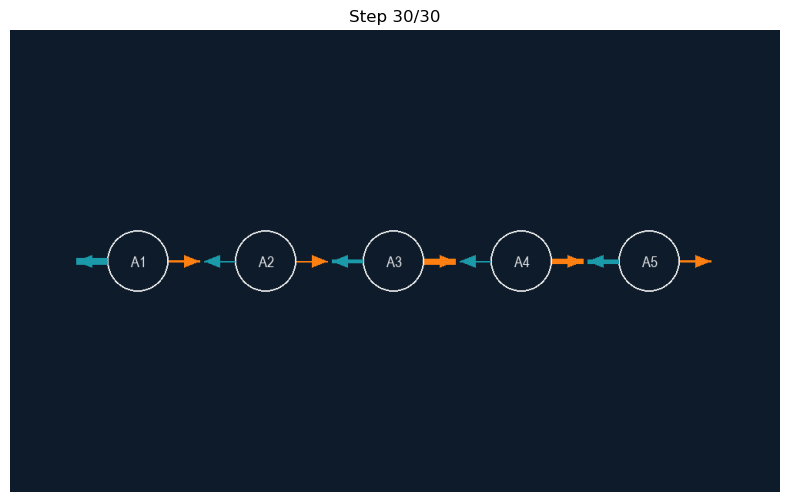

In [6]:
import pygame
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

# 配色
DEEP_BLUE = (13, 27, 42)
ORANGE = (255, 127, 17)
LIGHT_BLUE = (27, 154, 170)
WHITE = (240, 240, 240)

def draw_agent(screen, font, x, y, radius, agent_id, in_value=0.5, out_value=0.5):
    """
    绘制一个带输入输出值的 agent
    in_value / out_value: [0,1] 范围，用于控制箭头粗细
    """
    # 画圆
    pygame.draw.circle(screen, WHITE, (x, y), radius, 2)
    text = font.render(f"A{agent_id}", True, WHITE)
    screen.blit(text, (x - text.get_width()//2, y - text.get_height()//2))

    # 输入箭头（左边）
    in_thickness = max(1, int(2 + 8*in_value))
    pygame.draw.line(screen, LIGHT_BLUE, (x - radius - 40, y), (x - radius, y), in_thickness)
    pygame.draw.polygon(screen, LIGHT_BLUE, [
        (x - radius - 40, y),
        (x - radius - 20, y - 8),
        (x - radius - 20, y + 8)
    ])

    # 输出箭头（右边）
    out_thickness = max(1, int(2 + 8*out_value))
    pygame.draw.line(screen, ORANGE, (x + radius, y), (x + radius + 40, y), out_thickness)
    pygame.draw.polygon(screen, ORANGE, [
        (x + radius + 40, y),
        (x + radius + 20, y - 8),
        (x + radius + 20, y + 8)
    ])

def render_agents_dynamic(n_agents=4, steps=20, delay=0.3):
    """
    在 Jupyter 中动态渲染智能体输入输出变化
    """
    pygame.init()
    WIDTH, HEIGHT = 1000, 600
    screen = pygame.Surface((WIDTH, HEIGHT))  # 不开窗口
    font = pygame.font.SysFont("Arial", 20)
    positions = [(WIDTH//(n_agents+1)*(i+1), HEIGHT//2) for i in range(n_agents)]

    for step in range(steps):
        # 清屏
        screen.fill(DEEP_BLUE)

        # 模拟输入输出值 (随机 0~1)
        in_values = np.random.rand(n_agents)
        out_values = np.random.rand(n_agents)

        # 画所有智能体
        for i, (x, y) in enumerate(positions):
            draw_agent(screen, font, x, y, 40, i+1, in_values[i], out_values[i])

        # 转 numpy 显示
        data = pygame.surfarray.array3d(screen)
        data = np.transpose(data, (1, 0, 2))  # (H, W, C)

        clear_output(wait=True)
        plt.figure(figsize=(10,6))
        plt.imshow(data)
        plt.title(f"Step {step+1}/{steps}")
        plt.axis("off")
        display(plt.gcf())
        plt.close()
        time.sleep(delay)

# 示例运行
render_agents_dynamic(n_agents=5, steps=30, delay=0.2)


In [4]:
pip install pygame

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/10.6 MB 3.5 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/10.6 MB 3.6 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/10.6 MB 3.1 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/10.6 MB 3.2 MB/s eta 0:00:03
   ------------ --------------------------- 3.4/10.6 MB 3.3 MB/s eta 0:00:03
   --------------- ------------------------ 4.2/10.6 MB 3.4 MB/s eta 0:00:02
   ------------------- -------------------- 5.2/10.6 MB 3.6 MB/s eta 0:00:02
   --------------------- ------------------ 5.8/10.6 MB 3.5 MB/s eta 0:00:02
   ------------------------ --------------- 6.6/10.6 MB 3.5 MB/s eta 0:00:02
   ---------------------------- ----------- 7.6/10.6 MB 3.6 MB/s eta 0:00:01
   ------------------------------- -------- 8.4/10.6 MB 3.6 MB/s eta 0:00:01
   ---------------------------------- ----- 9.2/10.6 MB 3.7 MB/s eta 0:00:01
   ---